# MNIST with the new PyTorch 1.0.1
----------------------------------------------

This kernel is based on PyTorch 1.0.1 which has many new features compared to the old version, for example, Variable removed...
This kernel shows how to use PyTorch in a simple way. A general PyTorch training and testing pipeline can be concluded into the following steps:
1. Load original data in a specific data structure.
2. Use the specific data structure to construct a PyTorch Dataset ([torch.utils.data.Dataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset))
3. Create a neural networks, a Pytorch model([torch.nn.Module](https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module)), composed of many layers (e.g., [nn.Conv2d](https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d))
4. Load a batch from a PyTorch Dataset and feed it into the model.
5. Create a criterion (loss function) to compute loss.
6. Once the loss is computed, use it to do the backward propagation to get the gradient for every parameter in the model.
7. Use PyTorch optimizer (includes learning rate, weight decay and other hyper-parameters for training) to update the model.
8. After training, test the model on the test set.

Should you have any questions or suggestions, let's discuss in comments. :-)
This kernel is based on the kernel [CNN with PyTorch](https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy). Thanks for [Ryan Chang](https://www.kaggle.com/juiyangchang)'s sharing.

## Introduction
--------
This kernel follows the pipeline mentioned above. Use only about a hundred lines, you can get over 99.8% accuracy on the test set.

So, let's start!


In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Explore the Data

First, in order to process the input data, here is the CSV file, we must understand its data structure.

In [2]:
train_csv_path = '../input/train.csv'
test_csv_path = '../input/test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# have a glimpse of train dataframe structure
n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))
print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))
print(train_df.head())

# have a glimpse of test dataframe structure
n_test = len(test_df)
n_pixels = len(test_df.columns)
print('Number of test samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))
print(test_df.head())

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10
   label  pixel0  pixel1    ...     pixel781  pixel782  pixel783
0      1       0       0    ...            0         0         0
1      0       0       0    ...            0         0         0
2      1       0       0    ...            0         0         0
3      4       0       0    ...            0         0         0
4      0       0       0    ...            0         0         0

[5 rows x 785 columns]
Number of test samples: 28000
Number of test pixels: 784
   pixel0  pixel1  pixel2    ...     pixel781  pixel782  pixel783
0       0       0       0    ...            0         0         0
1       0       0       0    ...            0         0         0
2       0       0       0    ...            0         0         0
3       0       0       0    ...            0         0         0
4       0       0       0    ...            0         0         0

[5 rows x 784 columns]


Make sure to figure out the dataframe structure and the difference between the train dataframe and the test dataframe

### Display some images

Picture is more than word.

2, 5, 4, 3, 9, 1, 5, 4


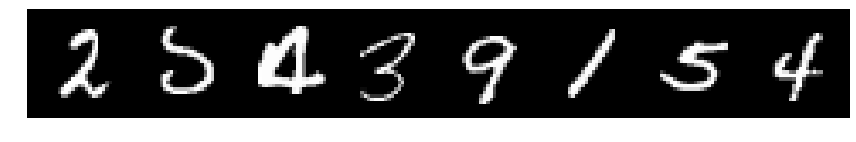

In [3]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

## Construct Data Sets from original csv file

### Pytorch Dataset Class
Details in [torch.data.dataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset)

The Pytorch's training pipeline is depicted in the following figure:

Must contains following member functions, in other words, we have to rewrite these member functions to adapt for our custom dataset:
* __init__()
* __getitem__()
* __len__()

A more detailed [DATA LOADING AND PROCESSING TUTORIAL](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) on PyTorch official website.

In [4]:
class MNISTDataset(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, dataframe, 
                 transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        df = dataframe
        # for MNIST dataset n_pixels should be 784
        self.n_pixels = 784
        
        if len(df.columns) == self.n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation, Shift, Affine Transformation
As you may notice, there is a `transform` parameter in our `MNISTDataset`'s construction method.

We use the `RandomAffine` transform function in the `torchvision.transforms` module to augment data. 
Here is the [link](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomAffine).
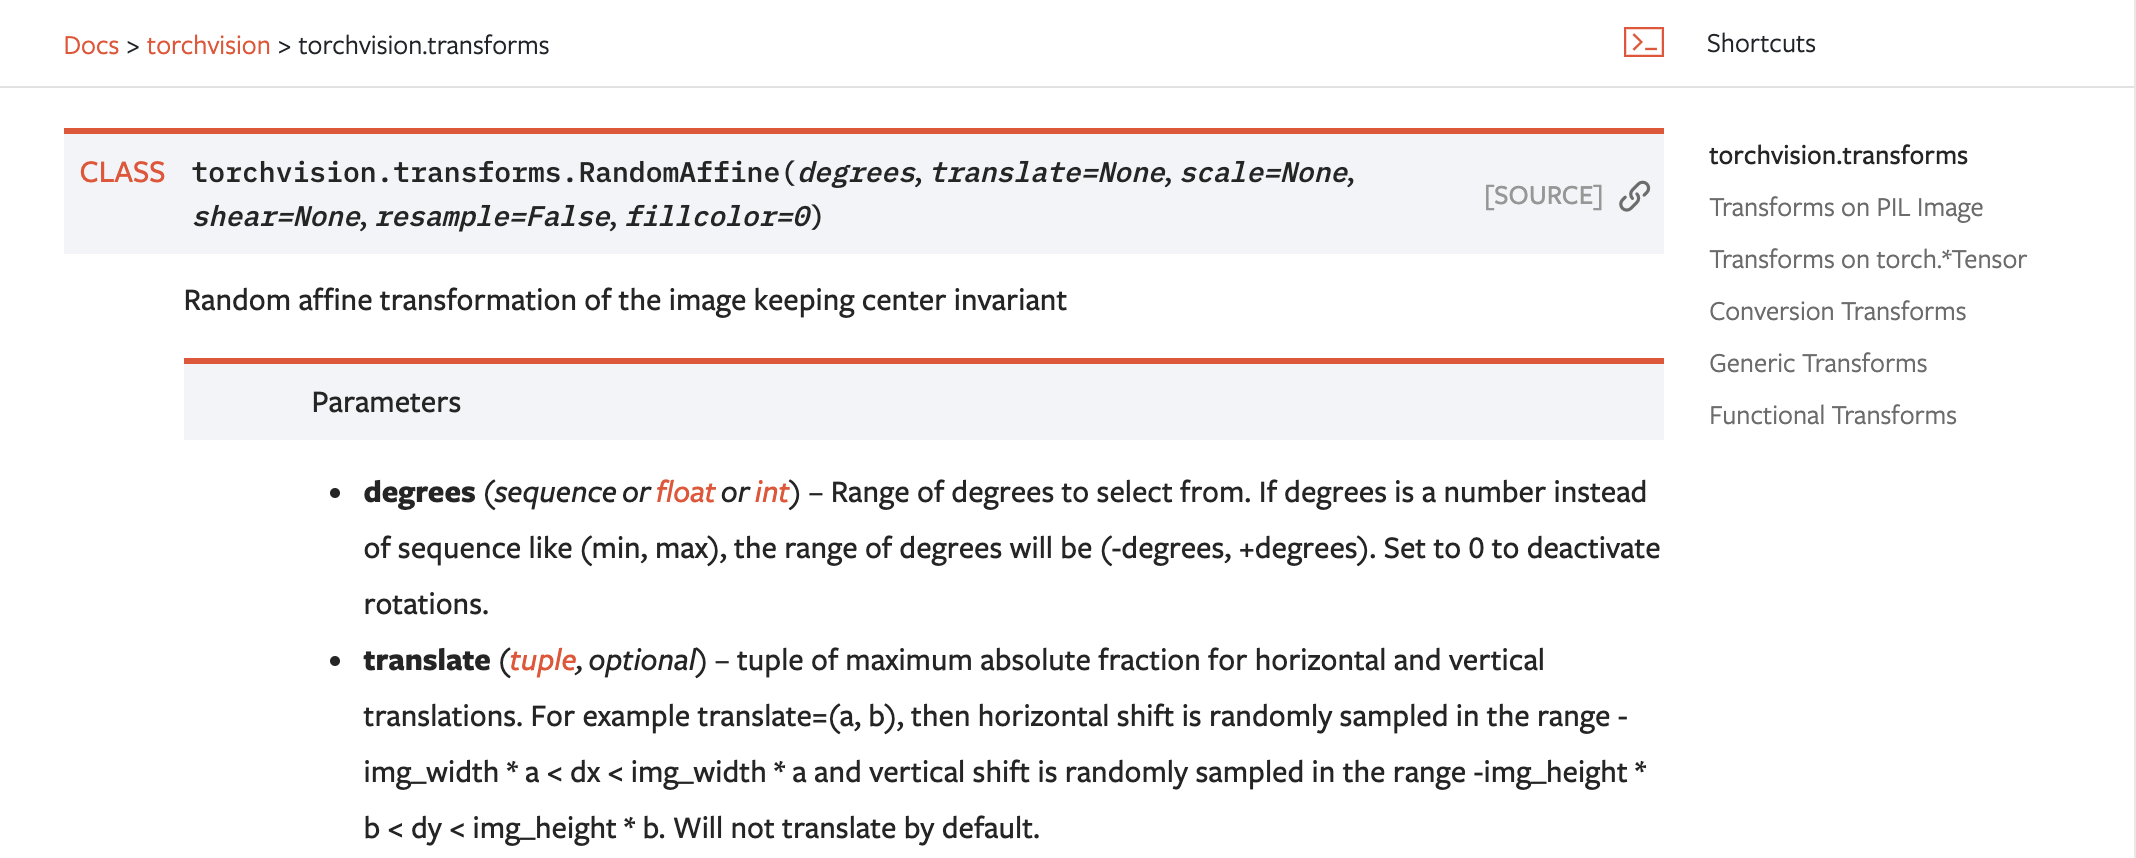

And also, you can use any other transforms you want.


In [5]:
RandAffine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2))

#### Visualize the Transformations

Again, picture is more than word.

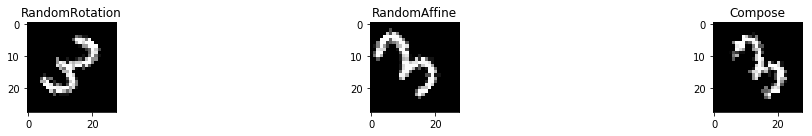

In [6]:
rotate = transforms.RandomRotation(degrees=45)
shift = RandAffine
composed = transforms.Compose([rotate,
                               shift])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Prepare the Dataset
For the training set, apply random affine transformation mentioned above and normalize pixel values to [-1, 1].
For the validation and test set, only apply nomalization.

Define a function `get_dataset()` as the PyTorch Dataset wrapper. There are two parameters:
* `dataframe`: The Pandas Dataframe to construct the dataset.
* `transform`: Transformations to be done when loading data.

In [7]:
batch_size = 64

train_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     RandAffine,
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

val_test_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

def get_dataset(dataframe, dataset=MNISTDataset,
                transform=transforms.Compose([transforms.ToPILImage(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5,), std=(0.5,))])):
    return dataset(dataframe, transform=transform)

## Modified ResNet18 Model for MNIST

First, let's take a look at all available models in the torchvision package.

The models subpackage contains definitions for the following model architectures:
- [AlexNet](https://arxiv.org/abs/1404.5997)
- [VGG](https://arxiv.org/abs/1409.1556)
- [ResNet](https://arxiv.org/abs/1512.03385)
- [SqueezeNet](https://arxiv.org/abs/1602.07360)
- [DenseNet](https://arxiv.org/abs/1608.06993)
- [Inception](https://arxiv.org/abs/1512.00567) v3
- [GoogLeNet](https://arxiv.org/abs/1409.4842)
- [ShuffleNet](https://arxiv.org/abs/1807.11164) v2

You can construct a model with random weights by calling its constructor:
```
>>> resnet18 = models.resnet18()
```

If you want to look closer to the source code of every model in torchvision package. You can find it on its official webpage or github repository. For example, the code of ResNet model is showed in the following page:
- [torchvision.models.resnet](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)

### Modify the official ResNet for MNIST

The official ResNet model is designed for the classification task on RGB image dataset, e.g. ImagNet. The main difference between ImageNet and MNIST is the following two points:

| Input Image  |      ImageNet      |       MNIST       |
| :---------:  | :----------------: | :---------------: |
|  Channels    |      3    |     1       |
| Resolution   | 224 x 224  | 28 x 28  |
| Classes  | 1000 | 10 |
So we should better do some modifications on the original networks to adapt for MNIST dataset. Specifically, add the following modifications:

* **Change the first convolutional layer to accept single channel input**
* **Change the stride of the first convolutional layer from 2 to 1**
* **Change the last fc layer's output features from 1000 to 10**

Before we start, in order to know which part of the code to modify, let's take a look how we get a model when calling the `torchvision.models.resnet18()` function.

Here is the source code of `torchvision.models.resnet18()`. When we construct the ResNet18 architecture, we are running the following procedure.

In [8]:
"""
Code snippet is used for introduction, there is no need to run this cell
"""

# def resnet18(pretrained=False, **kwargs):
#     """Constructs a ResNet-18 model.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
#     return model

'\nCode snippet is used for introduction, there is no need to run this cell\n'

The first two parameters:
* `BasicBlock`: The basic block for building ResNet, defined in the same file ([torchvision.models.resnet](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)). There is another kind of building block --- Bottleneck.
* `[2, 2, 2, 2]`: Each number denotes the number of Bottleneck or BasicBlock modules in a "stage". It depends on how deep you want the networks to be. For example, for ResNet18, it is `[2, 2, 2, 2]`; for ResNet34, it is `[3, 4, 6, 3]`.

Furthermore, ResNet18 model is a Instance of `ResNet` Class. And continue searching for the declaration of `ResNet` class in the same file ([torchvision.models.resnet](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)). We get:

In [9]:
"""
Code snippet is used for introduction, there is no need to run this cell
"""

# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
#                  groups=1, width_per_group=64, replace_stride_with_dilation=None,
#                  norm_layer=None):
#         super(ResNet, self).__init__()
#         ...
        
#         # declaration of first convolutional layer
#         self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,bias=False)
#         ...
        
#         self.fc = nn.Linear(512 * block.expansion, num_classes)
#         ...
    
#     def forward(self, x):
#         x = self.conv1(x)
#         ....

'\nCode snippet is used for introduction, there is no need to run this cell\n'

Now here are what we want to modify:
* The first convolutional layer declaration (input channels and stride)
* The output features of the last fc layer (`num_classes` parameter)

So we can do the following modifications to get our MNISTResNet model.

In [10]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

model = MNISTResNet()
print(model)

MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2

## Training and Evaluation

Define `train` function.

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # if GPU available, move data and target to GPU
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)
        
        # TODO:
        # 1. add batch metric (acc1, acc5)
        # 2. add average metric top1=sum(acc1)/batch_idx, top5 = sum(acc5)/batch_idx
        
        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))

Define `validate` function.

In [12]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader.dataset)
        
    print('\nOn Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100.0 * float(correct) / len(val_loader.dataset)))

Set the hyper-parameters for training.

Run 50 epoches with step_size=10, base_lr=0.01. Model will achieve over 99.5% accuracy on test set.

In [13]:
# example config, use the comments to get higher accuracy
total_epoches = 20 # 50
step_size = 5     # 10
base_lr = 0.01    # 0.01

optimizer = optim.Adam(model.parameters(), lr=base_lr)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

### Train the network
There is only train set and test set in MNIST dataset. In a more general case, we should have three non-overlap datasets:
* train set: used to train the model
* val set: used to adjust the hyper-parameters, e.g., learning rate, total epoches, weight decay ...
* test set: used to test our final model

So we can split the original train set into a new train set and a val set. Moreover, we can random select different samples every epoch.


In [14]:
def split_dataframe(dataframe=None, fraction=0.9, rand_seed=1):
    df_1 = dataframe.sample(frac=fraction, random_state=rand_seed)
    df_2 = dataframe.drop(df_1.index)
    return df_1, df_2

for epoch in range(total_epoches):
    print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))

    train_df_new, val_df = split_dataframe(dataframe=train_df, fraction=0.9, rand_seed=epoch)
    
    train_dataset = get_dataset(train_df_new, transform=train_transforms)
    val_dataset = get_dataset(val_df, transform=val_test_transforms)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size, shuffle=False)

    train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
    validate(val_loader=val_loader, model=model, criterion=criterion)
    exp_lr_scheduler.step()


Train Epoch 0: lr = 0.1
Train Epoch: 0 [6400/37800 (17%)]	Loss: 0.231636
Train Epoch: 0 [12800/37800 (34%)]	Loss: 0.368168
Train Epoch: 0 [19200/37800 (51%)]	Loss: 0.243764
Train Epoch: 0 [25600/37800 (68%)]	Loss: 0.415110
Train Epoch: 0 [32000/37800 (85%)]	Loss: 0.074966

On Val set Average loss: 0.0017, Accuracy: 4072/4200 (96.952%)


Train Epoch 1: lr = 0.01
Train Epoch: 1 [6400/37800 (17%)]	Loss: 0.251141
Train Epoch: 1 [12800/37800 (34%)]	Loss: 0.382899
Train Epoch: 1 [19200/37800 (51%)]	Loss: 0.090113
Train Epoch: 1 [25600/37800 (68%)]	Loss: 0.194072
Train Epoch: 1 [32000/37800 (85%)]	Loss: 0.122513

On Val set Average loss: 0.0016, Accuracy: 4069/4200 (96.881%)


Train Epoch 2: lr = 0.01
Train Epoch: 2 [6400/37800 (17%)]	Loss: 0.142681
Train Epoch: 2 [12800/37800 (34%)]	Loss: 0.354536
Train Epoch: 2 [19200/37800 (51%)]	Loss: 0.139507
Train Epoch: 2 [25600/37800 (68%)]	Loss: 0.089359
Train Epoch: 2 [32000/37800 (85%)]	Loss: 0.380017

On Val set Average loss: 0.0011, Accuracy: 41

## [Optional] How to get Acc 99.8% in title?

Actually, I noticed the discussion about [How to score 97%, 98%, 99%, and 100%](https://www.kaggle.com/c/digit-recognizer/discussion/61480)

As mentioned in the discussion, in order to get a 99.8% or higher accuracy, you have to add more data, which is unfair.

> * 99.8%: To score 99.8% and higher, you need to have an incredibly lucky training session, or you need to train with the full original MNIST dataset of 70,000 images which unfairly contains Kaggle's "test.csv" images.

However, we can have a try with all MNIST data.

In [15]:
"""
The following code train model with extra original MNIST data.
It's unfair.
"""

# from torchvision.datasets import MNIST

# train_transforms = transforms.Compose(
#     [RandAffine,
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0.5,), std=(0.5,))])

# val_test_transforms = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean=(0.5,), std=(0.5,))])

# train_dataset_all = MNIST('.', train=True, download=True,
#                           transform=train_transforms)
# test_dataset_all = MNIST('.', train=False, download=True,
#                          transform=train_transforms)

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset_all,
#                                            batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(dataset=test_dataset_all,
#                                          batch_size=batch_size, shuffle=False)


# for epoch in range(total_epoches):
#     print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
#     train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
#     validate(val_loader=val_loader, model=model, criterion=criterion)
#     exp_lr_scheduler.step()

"\nThe following code train model with extra original MNIST data.\nIt's unfair.\n"

## Prediction on Test Set

In [16]:
def prediciton(test_loader, model):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [17]:
test_batch_size = 64
test_dataset = get_dataset(test_df, transform=val_test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size, shuffle=False)

# tensor prediction
test_pred = prediciton(test_loader, model)

# tensor -> numpy.ndarray -> pandas.DataFrame
test_pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1), test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# show part of prediction dataframe
print(test_pred_df.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3


### Download the prediction file
Util for download file in a kernel.

Reference: [Download a .csv file from a kernel](https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel)

In [18]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link and click to download
create_download_link(test_pred_df, filename="submission.csv")

## Save submission file

In [19]:
test_pred_df.to_csv('submission.csv', index=False)